In [ ]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera, normaltest
import scipy.stats as stats
from statsmodels.tools.tools import add_constant
import pandas as pd

In [ ]:
data = pd.read_csv("/content/car_dataframe_complete.csv", encoding='utf-8')
data.head()

,fuel_consumption_km_l,traccion,transmision,horsepower,fuel_type,displacement,gears,engine_type,torque,turbo,brand,age,body_type
0,7,4x2,Automático,449,estándar,3.0,7,Combustión,516,Sí,Mercedes Benz,9,Sedan
1,10,4x4,Automático,310,estándar,3.0,8,Combustión,325,Sí,Audi,7,Sedan
2,11,4x4,Automático,300,estándar,2.0,8,Combustión,295,Sí,Jaguar Xe,6,Sedan
3,17,4x2,Automático,150,estándar,1.4,7,Combustión,148,Sí,Seat,6,Suv
4,12,4x4,Automático,320,Gasolina,2.0,8,Combustión,295,Sí,Volvo,7,Suv


# Limpieza de Datos

In [ ]:
correcciones_sin_acentos = {
    'transmision': {
        'Automático': 'automatico',
        'Manual': 'manual',
        'transmision': 'transmision'
    },
    'fuel_type': {
        'estándar': 'estandar',
        'Híbrido': 'hibrido',
        'Eléctrico': 'electrico',
        'NoInfo ':'NoInfo',
        'Gasolina':'Gasolina'

    },
    'body_type': {
        'Suv': 'suv',
        'Sedan': 'sedan',
        'body_ype': 'body_type'
    },
    'engine_type': {
        'Combustión': 'combustion',
        'Híbrido': 'hibrido',
        'Eléctrico': 'electrico',
        'NoInfo ':'NoInfo'
    },
    'turbo':{
        'Sí': 'si'
    }
}

for columna, correccion in correcciones_sin_acentos.items():
    data[columna] = data[columna].replace(correccion)


data.head()

,fuel_consumption_km_l,traccion,transmision,horsepower,fuel_type,displacement,gears,engine_type,torque,turbo,brand,age,body_type
0,7,4x2,automatico,449,estandar,3.0,7,combustion,516,si,Mercedes Benz,9,sedan
1,10,4x4,automatico,310,estandar,3.0,8,combustion,325,si,Audi,7,sedan
2,11,4x4,automatico,300,estandar,2.0,8,combustion,295,si,Jaguar Xe,6,sedan
3,17,4x2,automatico,150,estandar,1.4,7,combustion,148,si,Seat,6,suv
4,12,4x4,automatico,320,Gasolina,2.0,8,combustion,295,si,Volvo,7,suv


In [ ]:
data = data.dropna()

In [ ]:
data = data[['fuel_consumption_km_l', 'traccion', 'horsepower', 'displacement', 'engine_type', 'turbo', 'brand', 'age', 'body_type']]

In [ ]:
data = data[~data['engine_type'].str.contains('NoInfo', na=False)]

data.engine_type.value_counts()

,count
engine_type,
combustion,1772
electrico,40
hibrido,8
Mild Hybrid,8
Motor Supercargado,2


In [ ]:
data['engine_type_grouped'] = data['engine_type'].replace({
    'hibrido': 'Hibrido',
    'Mild Hybrid':'Hibrido',
    'Electrico': 'Electrico',
    'Supercargado': 'Otros',
    'Motor Supercargado':'Otros'
})

<ipython-input-7-2d7a0baa2ff2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['engine_type_grouped'] = data['engine_type'].replace({


In [ ]:
data['body_type_grouped'] = data['body_type'].replace({
    'sedan': 'Sedan/Coupe',
    'Coupe': 'Sedan/Coupe',
    'Convertible': 'Sedan/Coupe',
    'Targa': 'Sedan/Coupe',
    'suv': 'SUV/Camioneta',
    'Pickup': 'SUV/Camioneta',
    'Minivan': 'Vehiculos Familiares',
    'Wagon': 'Vehiculos Familiares',
    'Van': 'Vehiculos Familiares',
    'Hatchback': 'Compactos'
})

<ipython-input-8-aa8ff72083e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['body_type_grouped'] = data['body_type'].replace({


In [ ]:
data.head()

,fuel_consumption_km_l,traccion,horsepower,displacement,engine_type,turbo,brand,age,body_type,engine_type_grouped,body_type_grouped
0,7,4x2,449,3.0,combustion,si,Mercedes Benz,9,sedan,combustion,Sedan/Coupe
1,10,4x4,310,3.0,combustion,si,Audi,7,sedan,combustion,Sedan/Coupe
2,11,4x4,300,2.0,combustion,si,Jaguar Xe,6,sedan,combustion,Sedan/Coupe
3,17,4x2,150,1.4,combustion,si,Seat,6,suv,combustion,SUV/Camioneta
4,12,4x4,320,2.0,combustion,si,Volvo,7,suv,combustion,SUV/Camioneta


In [ ]:
data.drop(columns=['body_type'], inplace=True)
data.drop(columns=['engine_type'], inplace=True)

In [ ]:
data.head()

,fuel_consumption_km_l,traccion,horsepower,displacement,turbo,brand,age,engine_type_grouped,body_type_grouped
0,7,4x2,449,3.0,si,Mercedes Benz,9,combustion,Sedan/Coupe
1,10,4x4,310,3.0,si,Audi,7,combustion,Sedan/Coupe
2,11,4x4,300,2.0,si,Jaguar Xe,6,combustion,Sedan/Coupe
3,17,4x2,150,1.4,si,Seat,6,combustion,SUV/Camioneta
4,12,4x4,320,2.0,si,Volvo,7,combustion,SUV/Camioneta


In [ ]:
brands_to_drop = ['Chevrolet', 'Nissan', 'Volkswagen','Audi','Honda','Mazda','Baic X65','Ford','Bmw','Kia']
data = data[~data['brand'].isin(brands_to_drop)]
data = data.drop(columns=['brand'])

In [ ]:
data.columns

Index(['fuel_consumption_km_l', 'traccion', 'horsepower', 'displacement',
       'turbo', 'age', 'engine_type_grouped', 'body_type_grouped'],
      dtype='object')

In [ ]:
data.shape

(788, 8)

In [ ]:
data_with_dummies = pd.get_dummies(data, drop_first=True)
data_with_dummies = data_with_dummies.replace({True: 1, False: 0})
data_with_dummies.head()

<ipython-input-15-61181f3c2e50>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_with_dummies = data_with_dummies.replace({True: 1, False: 0})


,fuel_consumption_km_l,horsepower,displacement,age,traccion_4x4,turbo_si,engine_type_grouped_Otros,engine_type_grouped_combustion,engine_type_grouped_electrico,body_type_grouped_SUV/Camioneta,body_type_grouped_Sedan/Coupe,body_type_grouped_Vehiculos Familiares
0,7,449,3.0,9,0,1,0,1,0,0,1,0
2,11,300,2.0,6,1,1,0,1,0,0,1,0
3,17,150,1.4,6,0,1,0,1,0,1,0,0
4,12,320,2.0,7,1,1,0,1,0,1,0,0
5,9,302,3.5,11,1,0,0,1,0,1,0,0


In [ ]:
data_with_dummies.shape

(788, 12)

## Split Train/Test

In [ ]:
#from sklearn.model_selection import train_test_split

#train_df, test_df = train_test_split(data_with_dummies, test_size=0.2,random_state=1)

#train_df.to_csv('train_df.csv')
#test_df.to_csv('test_df.csv')

# Evaluación del modelo

## Entrenamiento inicial

In [ ]:
X_lin = data_with_dummies.drop(columns=['fuel_consumption_km_l'])
y_lin = data_with_dummies['fuel_consumption_km_l']

X_lin_with_const = sm.add_constant(X_lin)

model_lin_lin = sm.OLS(y_lin, X_lin_with_const).fit()

In [ ]:
model_lin_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     fuel_consumption_km_l   R-squared:                       0.792
Model:                               OLS   Adj. R-squared:                  0.789
Method:                    Least Squares   F-statistic:                     268.6
Date:                   Mon, 07 Oct 2024   Prob (F-statistic):          8.13e-256
Time:                           04:27:27   Log-Likelihood:                -1668.8
No. Observations:                    788   AIC:                             3362.
Df Residuals:                        776   BIC:                             3418.
Df Model:                             11                                         
Covariance Type:               nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     19.6558      0.828     23.751      0.000      18.031      21.280
horsepower                                -0.0281      0.003    -11.054      0.000      -0.033      -0.023
displacement                              -0.1600      0.208     -0.768      0.442      -0.569       0.249
age                                       -0.1271      0.036     -3.568      0.000      -0.197      -0.057
traccion_4x4                               0.4000      0.260      1.536      0.125      -0.111       0.911
turbo_si                                   0.3407      0.209      1.628      0.104      -0.070       0.751
engine_type_grouped_Otros                  1.4923      1.645      0.907      0.364      -1.736       4.721
engine_type_grouped_combustion             0.2085      0.786      0.265      0.791      -1.334       1.751
engine_type_grouped_electrico             13.2945      0.906     14.678      0.000      11.517      15.072
body_type_grouped_SUV/Camioneta           -1.9512      0.206     -9.450      0.000      -2.357      -1.546
body_type_grouped_Sedan/Coupe             -0.1874      0.223     -0.841      0.401      -0.625       0.250
body_type_grouped_Vehiculos Familiares    -1.6985      0.349     -4.872      0.000      -2.383      -1.014
==============================================================================
Omnibus:                       61.685   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.409
Skew:                          -0.578   Prob(JB):                     1.92e-21
Kurtosis:                       4.253   Cond. No.                     5.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
residuals = model_lin_lin.resid

mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
print(f"MSE: {mse: .3f}")
print(f"RMSE: {rmse: .3f}")

MSE:  4.046
RMSE:  2.011


## Pruebas de Supuestos

### Multicolinealidad

In [ ]:
vif_data = pd.DataFrame()
vif_data['Variable'] = X_lin_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_lin_with_const.values, i) for i in range(X_lin_with_const.shape[1])]

# Mostrar el resultado del VIF
print(vif_data[1:-1])

                           Variable       VIF
1                        horsepower  8.897285
2                      displacement  8.276143
3                               age  1.217915
4                      traccion_4x4  1.835168
5                          turbo_si  1.966220
6         engine_type_grouped_Otros  1.313426
7    engine_type_grouped_combustion  4.614186
8     engine_type_grouped_electrico  4.458699
9   body_type_grouped_SUV/Camioneta  2.030829
10    body_type_grouped_Sedan/Coupe  1.498293


#### Correción de multicolinealidad con dummies

In [ ]:
# Se crea una variable 'dummy' a partir de dos variables numéricas
# El criterio es sumar ambas variables

data_with_dummies['hp_disp_weighted'] = data_with_dummies['horsepower'] + data_with_dummies['displacement']

data_with_dummies = data_with_dummies.drop(columns=['horsepower', 'displacement'])

In [ ]:
data_with_dummies.head()

,fuel_consumption_km_l,age,traccion_4x4,turbo_si,engine_type_grouped_Otros,engine_type_grouped_combustion,engine_type_grouped_electrico,body_type_grouped_SUV/Camioneta,body_type_grouped_Sedan/Coupe,body_type_grouped_Vehiculos Familiares,hp_disp_weighted
0,7,9,0,1,0,1,0,0,1,0,452.0
2,11,6,1,1,0,1,0,0,1,0,302.0
3,17,6,0,1,0,1,0,1,0,0,151.4
4,12,7,1,1,0,1,0,1,0,0,322.0
5,9,11,1,0,0,1,0,1,0,0,305.5


In [ ]:
#from sklearn.model_selection import train_test_split

#train_df, test_df = train_test_split(data_with_dummies, test_size=0.2,random_state=2)

#train_df.to_csv('train_df_2.csv')
#test_df.to_csv('test_df_2.csv')

### Entrenamiento de modelo 2 (Lin-Lin)

In [ ]:
# Train

X_lin = data_with_dummies.drop(columns=['fuel_consumption_km_l'])
y_lin = data_with_dummies['fuel_consumption_km_l']

X_lin_with_const = sm.add_constant(X_lin)

model_lin_lin = sm.OLS(y_lin, X_lin_with_const).fit()

In [ ]:
model_lin_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     fuel_consumption_km_l   R-squared:                       0.792
Model:                               OLS   Adj. R-squared:                  0.789
Method:                    Least Squares   F-statistic:                     295.6
Date:                   Mon, 07 Oct 2024   Prob (F-statistic):          5.61e-257
Time:                           04:27:28   Log-Likelihood:                -1669.0
No. Observations:                    788   AIC:                             3360.
Df Residuals:                        777   BIC:                             3411.
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     19.5975      0.822     23.841      0.000      17.984      21.211
age                                       -0.1294      0.035     -3.653      0.000      -0.199      -0.060
traccion_4x4                               0.4207      0.258      1.630      0.104      -0.086       0.927
turbo_si                                   0.4270      0.157      2.714      0.007       0.118       0.736
engine_type_grouped_Otros                  1.5476      1.642      0.943      0.346      -1.675       4.770
engine_type_grouped_combustion             0.2219      0.785      0.283      0.778      -1.319       1.763
engine_type_grouped_electrico             13.3260      0.904     14.742      0.000      11.552      15.101
body_type_grouped_SUV/Camioneta           -1.9589      0.206     -9.508      0.000      -2.363      -1.555
body_type_grouped_Sedan/Coupe             -0.1758      0.222     -0.792      0.429      -0.612       0.260
body_type_grouped_Vehiculos Familiares    -1.7230      0.346     -4.976      0.000      -2.403      -1.043
hp_disp_weighted                          -0.0295      0.001    -24.088      0.000      -0.032      -0.027
==============================================================================
Omnibus:                       61.774   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.684
Skew:                          -0.578   Prob(JB):                     1.67e-21
Kurtosis:                       4.256   Cond. No.                     5.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Multicolinealidad

In [ ]:
vif_data = pd.DataFrame()
vif_data['Variable'] = X_lin_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_lin_with_const.values, i) for i in range(X_lin_with_const.shape[1])]

# Mostrar el resultado del VIF
print(vif_data[1:-1])

                                 Variable       VIF
1                                     age  1.205179
2                            traccion_4x4  1.805423
3                                turbo_si  1.112968
4               engine_type_grouped_Otros  1.309648
5          engine_type_grouped_combustion  4.610763
6           engine_type_grouped_electrico  4.444913
7         body_type_grouped_SUV/Camioneta  2.023623
8           body_type_grouped_Sedan/Coupe  1.487963
9  body_type_grouped_Vehiculos Familiares  1.213323


#### Heterocedasticidad

In [ ]:
# Realizar la prueba de White para heterocedasticidad
white_test = het_white(residuals, model_lin_lin.model.exog)
white_test

(319.2604173792208,
 3.756534291438482e-46,
 13.424918849735956,
 1.5646777514419424e-61)

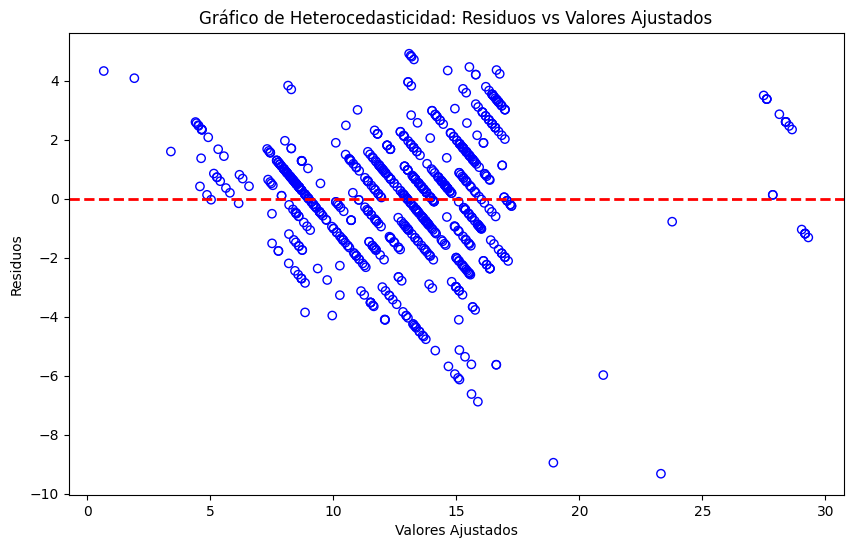

In [ ]:
# Gráfico de dispersión para verificar la heterocedasticidad
plt.figure(figsize=(10,6))
plt.scatter(model_lin_lin.fittedvalues, model_lin_lin.resid, edgecolors='b', facecolors='none')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title('Gráfico de Heterocedasticidad: Residuos vs Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()

#### Autocorrelación

In [ ]:
durbin_watson_test = durbin_watson(model_lin_lin.resid)
durbin_watson_test

1.9935371802429294

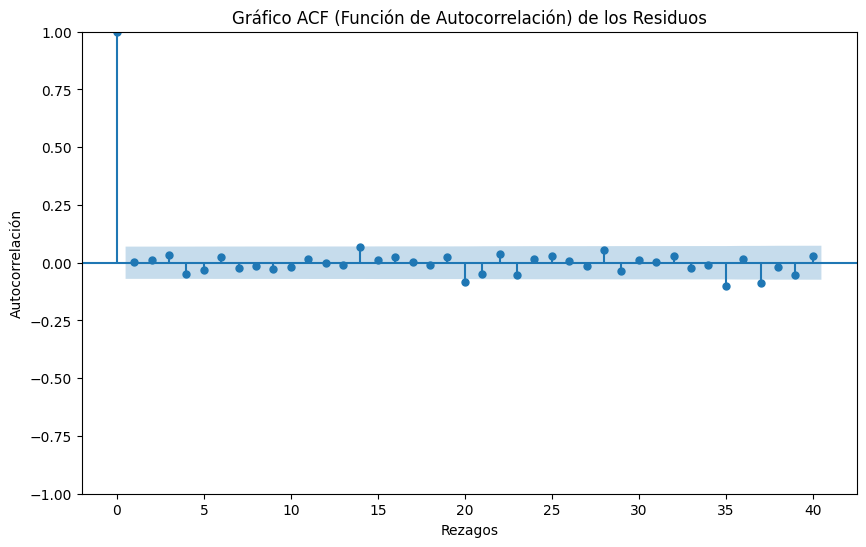

In [ ]:
#correlograma

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Gráfico ACF (Autocorrelation Function) para los residuos del modelo
fig, ax = plt.subplots(figsize=(10,6))
sm.graphics.tsa.plot_acf(model_lin_lin.resid, lags=40, ax=ax)
plt.title('Gráfico ACF (Función de Autocorrelación) de los Residuos')
plt.xlabel('Rezagos')
plt.ylabel('Autocorrelación')
plt.show()

#### No Normalidad en Errores

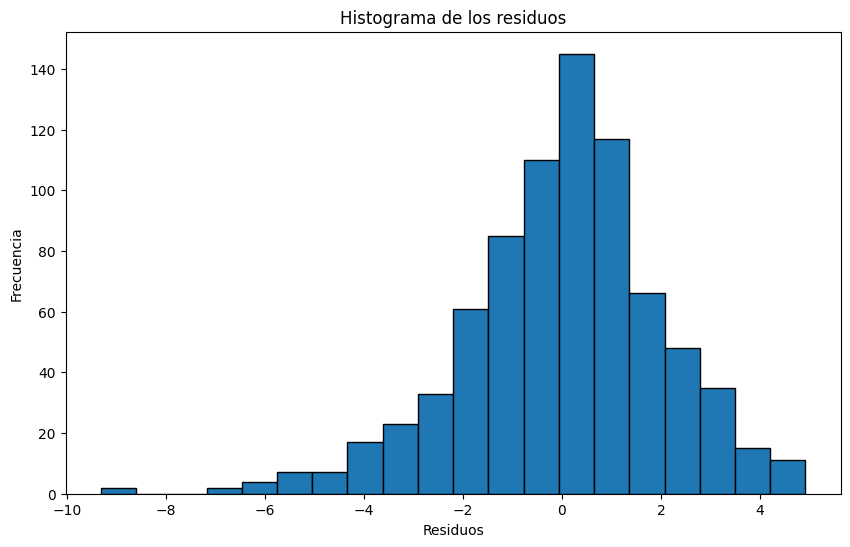

In [ ]:
# Histograma de los residuos
plt.figure(figsize=(10,6))
plt.hist(model_lin_lin.resid, bins=20, edgecolor='black')
plt.title('Histograma de los residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

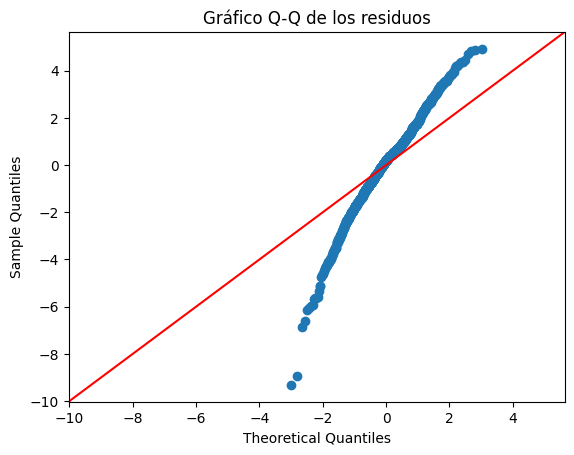

In [ ]:
 # Gráfico Q-Q
sm.qqplot(model_lin_lin.resid, line ='45')
plt.title('Gráfico Q-Q de los residuos')
plt.show()

### Evaluación del modelo 2 (Lin-Lin)

In [ ]:
# Test

X_test_lin = data_with_dummies.drop(columns=['fuel_consumption_km_l'])
X_test_with_const = sm.add_constant(X_test_lin)

data_with_dummies['y_pred'] = model_lin_lin.predict(X_test_with_const)

In [ ]:
y = data_with_dummies['fuel_consumption_km_l']

y_pred = model_lin_lin.predict(X_lin_with_const)

residuales = y - y_pred

mse = np.mean(residuals ** 2)
rmse = np.sqrt(mse)

ss_res = np.sum(residuales ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2 = 1 - (ss_res / ss_tot)


print(f"MSE: {mse: .3f}")
print(f"RMSE: {rmse: .3f}")
print(f"R2: {r2: .3f}")

MSE:  4.046
RMSE:  2.011
R2:  0.792


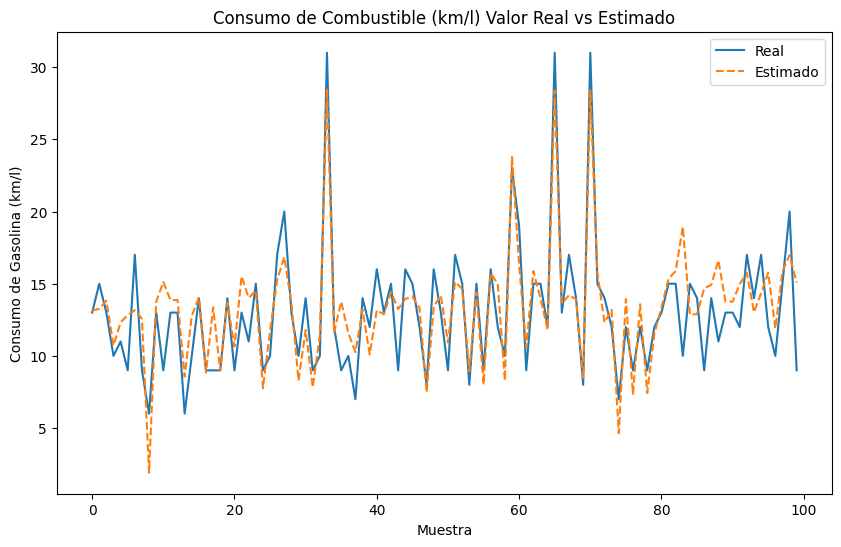

In [ ]:
import matplotlib.pyplot as plt

y_actual_sample = y[19:119]
y_pred_sample = y_pred[19:119]

plt.figure(figsize=(10,6))
plt.plot(y_actual_sample.values, label="Real")
plt.plot(y_pred_sample.values, label="Estimado", linestyle='--')
plt.title('Consumo de Combustible (km/l) Valor Real vs Estimado')
plt.xlabel('Muestra')
plt.ylabel('Consumo de Gasolina (km/l)')
plt.legend()
plt.show()